In [1]:
import torch
import pickle
import os
from PIL import Image
from torch.nn.functional import softmax
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from IPython.utils import io
torch.set_printoptions(sci_mode=False)

## General Setup

In [2]:
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
os.chdir(f"{ROOT_PATH}/4_Assessor/Category_Assessor/DinoV2")
from helpers_pipeline import *
from helper_DinoV2_Embeddings import *
id2label = pickle.load(open("id2label_dicts/category_id2label.pkl", "rb"))
label2id = {v: k for k, v in id2label.items()}
os.chdir(current_wd)

Using devices: DinoV2 device: cpu | SG2 device: mps | General device: mps


In [4]:
set_seed(42)
dino_device, sg2_device, device = set_device()

Using devices: DinoV2 device: cpu | SG2 device: mps | General device: mps


## Fixed Models Setup

In [5]:
# Products data and latents
target_feature = 'category'
df, latents = load_latents(target_feature)
latents = latents.to(sg2_device)

# SG2-Ada Generator
G = setup_generator()
G = G.to(sg2_device)

# DinoV2 Model 
dino_processor, dino_model = setup_dinov2()
dino_model = dino_model.to(dino_device)

# Attribute Classifier Model
classifier = load_classifier()
classifier = classifier.to(device)

In [6]:
# Freeeze all non-relevant model weights and set to eval mode
for param in G.parameters():
    param.requires_grad = False
G.eval()
for param in dino_model.parameters():
    param.requires_grad = False
dino_model.eval()
for param in classifier.parameters():
    param.requires_grad = False
classifier.eval();


In [7]:
# Print device for each model: 
print(f"Generator: {next(G.parameters()).device} | Requires Grad: {next(G.parameters()).requires_grad}")
print(f"DinoV2: {next(dino_model.parameters()).device} | Requires Grad: {next(dino_model.parameters()).requires_grad}")
print(f"Classifier: {next(classifier.parameters()).device} | Requires Grad: {next(classifier.parameters()).requires_grad}")

Generator: mps:0 | Requires Grad: False
DinoV2: cpu | Requires Grad: False
Classifier: mps:0 | Requires Grad: False


In [8]:
def plot_generated(img):
    img_out = (img.permute(0,2,3,1)*127.5 + 128).clamp(0,255).to(torch.uint8)
    img_out = Image.fromarray(img_out[0].cpu().numpy())
    return img_out

### Test Image Memorability Manipualtions instead of Own Assessor

In [9]:
from resmem import ResMem, transformer
model = ResMem(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model = model.to('cpu')
model.eval();

transformer = transforms.Compose([
    transforms.Resize(size = (256, 256)),
    transforms.CenterCrop(size = (227, 227))
])

/Users/maltegenschow/.pyenv/versions/3.10.1/envs/master_thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maltegenschow/.pyenv/versions/3.10.1/envs/master_thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
img_path = '/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync/Zalando_Germany_Dataset/dresses/images/square_images/0FB21C03L-E11.jpg'
img = Image.open(img_path).convert('RGB')
img = transforms.ToTensor()(img)
img = img.to('cpu')
img = transformer(img).unsqueeze(0)
mem_score = model(img)
mem_score

tensor([[0.8615]])

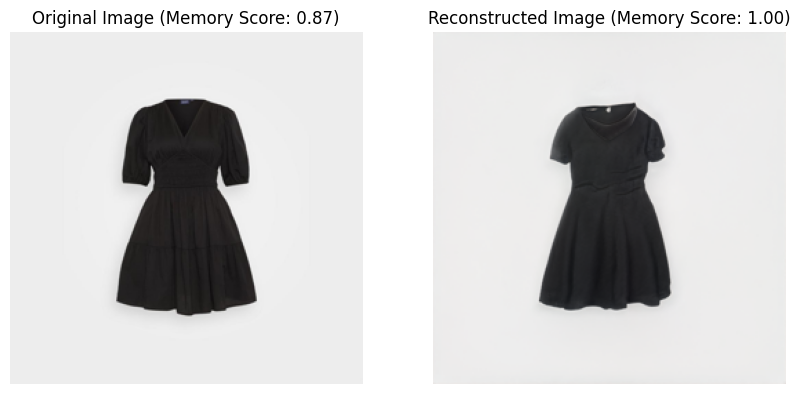

In [11]:
# Draw one sample
sample = df.sample(1)
latent_idx = sample.latent_idx.item()
latent = latents[latent_idx].unsqueeze(0)

# Plot image and reconsutructed image
orig = Image.open(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/{sample.sku.item()}.jpg").convert('RGB').resize((256, 256))
recon = G.synthesis(latent.squeeze(0), noise_mode='const')
recon_out = (recon.permute(0,2,3,1)*127.5 + 128).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
recon_out = Image.fromarray(recon_out).resize((256, 256))

# Compute memory scores
orig_trans = transformer(transforms.ToTensor()(orig).unsqueeze(0))
orig_score = model(orig_trans)
recon_trans = transformer(recon.to('cpu'))
recon_score = model(recon_trans)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(orig)
ax[0].set_title("Original Image (Memory Score: {:.2f})".format(orig_score.item()))
ax[0].axis('off')
ax[1].imshow(recon_out)
ax[1].set_title("Reconstructed Image (Memory Score: {:.2f})".format(recon_score.item()))
ax[1].axis('off')
plt.show()

### 1. Test Memorability Manipulations in Z-Space

In [12]:
z = torch.randn(1, 512).to(sg2_device)

Loss: 0.24870729446411133, Gradient Norm: 0.00412609800696373, Score: 0.9987056255340576


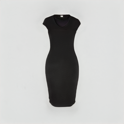

Loss: 0.14076530933380127, Gradient Norm: 0.3610345125198364, Score: 0.8751870393753052


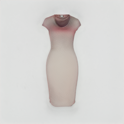

Loss: 0.1356543004512787, Gradient Norm: 0.24205996096134186, Score: 0.8683127760887146


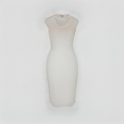

Loss: 0.1352236568927765, Gradient Norm: 0.15304693579673767, Score: 0.8677276968955994


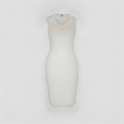

Loss: 0.12310085445642471, Gradient Norm: 0.2099662572145462, Score: 0.8508573174476624


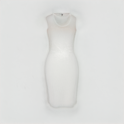

In [13]:
directions = torch.ones(1, 512, device=latent.device, requires_grad=True)
target = torch.tensor([0.5])

optimizer = torch.optim.Adam([directions], lr=0.05)
loss = nn.MSELoss(reduction='sum')

for i in range(5):
    optimizer.zero_grad()
    z_new = z + directions
    w = G.mapping(z_new, None)
    new_img = G.synthesis(w, noise_mode='const')
    plot_img = plot_generated(new_img)
    new_img = transformer(new_img.to('cpu'))
    score = model(new_img)
    l = loss(target, score.squeeze(0))
    l.backward()
    optimizer.step()
    print(f"Loss: {l.item()}, Gradient Norm: {directions.grad.norm()}, Score: {score.item()}")
    display(plot_img.resize((124, 124)))

### 2. Test Memorability Manipulations in W-Space

In [20]:
latent = latents[4]
latent.shape

torch.Size([1, 16, 512])

Step 0: Loss: 0.24860167503356934, Gradient Norm: 0.003750360570847988, Score: 0.9985997080802917


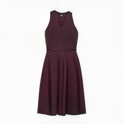

Step 5: Loss: 0.12111561000347137, Gradient Norm: 0.1698659509420395, Score: 0.8480166792869568


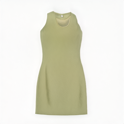

Step 10: Loss: 0.07354814559221268, Gradient Norm: 0.1651233434677124, Score: 0.7711976170539856


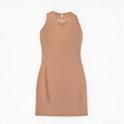

Step 15: Loss: 0.049334216862916946, Gradient Norm: 0.09743401408195496, Score: 0.7221130728721619


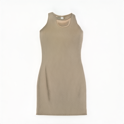

Step 20: Loss: 0.05066066235303879, Gradient Norm: 0.09108036011457443, Score: 0.7250792384147644


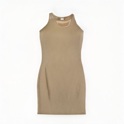

Step 25: Loss: 0.04013416916131973, Gradient Norm: 0.10266895592212677, Score: 0.7003351449966431


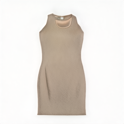

Step 30: Loss: 0.026533642783761024, Gradient Norm: 0.07948605716228485, Score: 0.6628915071487427


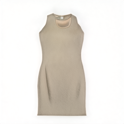

Step 35: Loss: 0.019230252131819725, Gradient Norm: 0.09332042932510376, Score: 0.6386731863021851


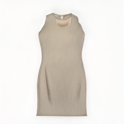

In [21]:
directions = torch.zeros([1, 16, 512], device=latent.device, requires_grad=True)
target = torch.tensor([0.5])

optimizer = torch.optim.Adam([directions], lr=0.03)
loss = nn.MSELoss(reduction='sum')

for i in range(40):
    optimizer.zero_grad()
    new_latent = latent + directions
    new_img = G.synthesis(new_latent, noise_mode='const')
    plot_img = plot_generated(new_img)
    new_img = transformer(new_img.to('cpu'))
    score = model(new_img)
    l = loss(target, score.squeeze(0))
    l.backward()
    optimizer.step()
    if i % 5 == 0:
        print(f"Step {i}: Loss: {l.item()}, Gradient Norm: {directions.grad.norm()}, Score: {score.item()}")
        display(plot_img.resize((124, 124)))